In [1]:
import os
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset


class CoronarySmallDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])
        

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        # image = cv2.cvtColor(image, cv2.COLOR_RGBA2GRAY)
        # print(image.shape)
        image = cv2.resize(image, (256, 256))
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        # mask = cv2.cvtColor(mask, cv2.COLOR_RGBA2GRAY)
        # print(mask.shape)
        mask = cv2.resize(mask, (256, 256))
        
        if self.transform:
            image = self.transform(image)
            # mask = self.transform(mask)
            mask = torch.tensor(mask, dtype=torch.long)
        
        return image, mask

In [2]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


transform = transforms.Compose([
    transforms.ToTensor()
])

train_image_dir = 'images_train\input'
train_mask_dir = 'images_train\output'
val_image_dir = 'images_val\input'
val_mask_dir = 'images_val\output'
test_image_dir = 'images_test\input'
test_mask_dir = 'images_test\output'

train_dataset = CoronarySmallDataset(train_image_dir, train_mask_dir, transform=transform)
val_dataset = CoronarySmallDataset(val_image_dir, val_mask_dir, transform=transform)
test_dataset = CoronarySmallDataset(test_image_dir, test_mask_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=12, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=12, shuffle=False)


In [3]:
from medium_RGB_model import UNet


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet()
model = model.to(device)

In [4]:
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


# criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_losses = []
val_losses = []

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    best_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, masks in tqdm(train_loader):
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
        
        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)
                
                val_loss += loss.item() * images.size(0)
        
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), 'medium_RGB_model.pth')

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()


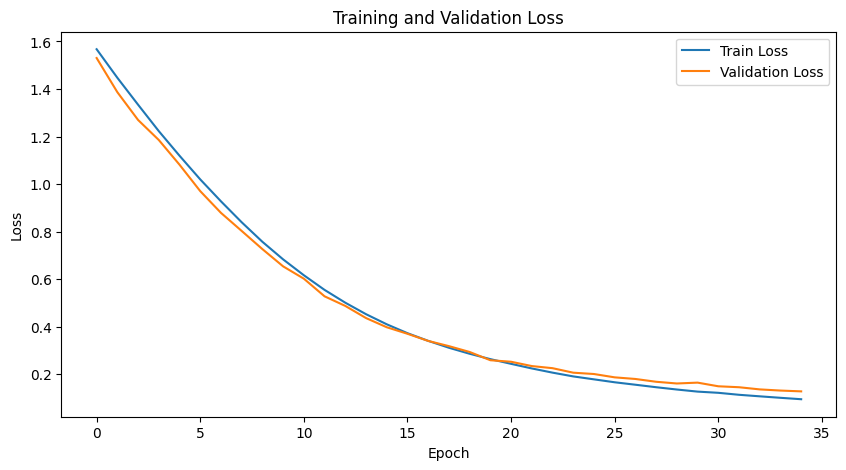

In [20]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=35)

In [24]:
import os
import numpy as np
import cv2
import torch
from torchvision import transforms
from converter_RGB import convert_int_to_RGB


model.load_state_dict(torch.load('medium_RGB_model.pth'))
model.eval()

def show_image(type, image_name):
    dir = f"images_test\{type}"
    print(dir)
    img = cv2.imread(os.path.join(dir, image_name), cv2.IMREAD_GRAYSCALE)
    # img = cv2.resize(img, (256, 256))
    if type == 'output':
        img = convert_int_to_RGB(img)
    else:
        img = img * 7
    # np.set_printoptions(threshold=np.inf)
    cv2.imshow(type, img)

def predict(image_name):
    dir = 'images_test\input'
    img = cv2.imread(os.path.join(dir, image_name), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256))
    img = transforms.ToTensor()(img).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model.predict(img)
        pred = pred.squeeze().cpu().numpy()
        print(pred)
    
    # pred_image = pred * 8 * 4
    # print(pred_image)
    # print(pred_image.max())
    # pred_image = pred_image.astype(np.uint8)
    pred_image = convert_int_to_RGB(pred)
    print(pred_image)
    try :
        pred_image = cv2.resize(pred_image, (512, 512))
        cv2.imshow('pred', pred_image)
        cv2.waitKey(0)
    except:
        print('error')
    cv2.waitKey(0)
   

In [25]:
# image_name = "13c2ur549vohc0jat2dvu3xs7q1_18.png"
# image_name = "13c2ur549vohc0jat2wd23me01_25.png"
# image_name = "131aedfhs6pnf1fvtvp49mg85r6e9f0r22_37.png"
image_name = "131aedfhs6pnf1fvtvp49juwu7plj9dv22_40.png"
show_image("input", image_name)
show_image("output", image_name)
predict(image_name)

images_test\input
images_test\output
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [11]:
model.load_state_dict(torch.load('medium_RGB_model.pth'))

def dice_coefficient(y_true, y_pred):
    smooth = 1.0
    y_true_f = y_true.view(-1)
    y_pred_f = y_pred.view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    return (2. * intersection + smooth) / (y_true_f.sum() + y_pred_f.sum() + smooth)

model.eval()
test_loss = 0.0
dice_scores = []

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)
        
        test_loss += loss.item() * images.size(0)
        dice_scores.append(dice_coefficient(masks, outputs))

test_loss = test_loss / len(test_loader.dataset)
mean_dice = torch.mean(torch.tensor(dice_scores))

print(f'Test Loss: {test_loss:.4f}')
print(f'Mean Dice Coefficient: {mean_dice:.4f}')


Test Loss: 0.5773
Mean Dice Coefficient: 0.6904


In [ ]:
from skimage import morphology

def post_process(prediction):
    prediction_np = prediction.cpu().numpy()
    processed = morphology.remove_small_objects(prediction_np > 0.5, min_size=100)
    processed = morphology.remove_small_holes(processed, area_threshold=100)
    return torch.tensor(processed, device=device)

post_processed_predictions = [post_process(pred) for pred in outputs]


In [ ]:
from flask import Flask, request, jsonify
import io

app = Flask(__name__)
model.load_state_dict(torch.load('model.pth'))
model.eval()

@app.route('/predict', methods=['POST'])
def predict():
    file = request.files['image']
    img_bytes = file.read()
    img = cv2.imdecode(np.frombuffer(img_bytes, np.uint8), cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    img = cv2.resize(img, (512, 512))
    img = transforms.ToTensor()(img).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(img)
        pred = pred.squeeze().cpu().numpy()
        pred = (pred > 0.5).astype(np.uint8)
    
    _, buffer = cv2.imencode('.png', pred)
    response = io.BytesIO(buffer)
    response.seek(0)
    return response, 200, {'Content-Type': 'image/png'}

if __name__ == '__main__':
    app.run()
